# Start from curve + Spline merging

for noise-free points only

In [1]:
from PIL import Image
import numpy as np
import scipy.optimize
import matplotlib.pyplot as plt
from time import perf_counter


Generate spline

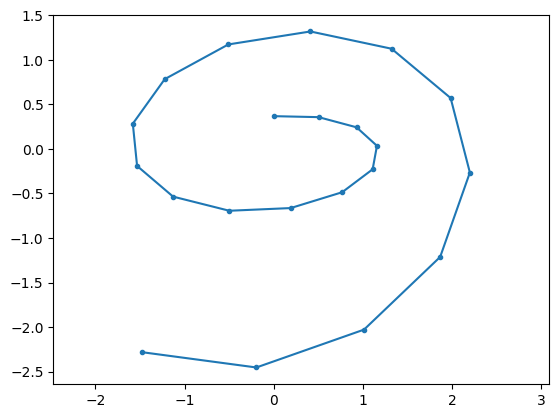

In [7]:
N = 20

def fun(t):
    return np.array([
        np.exp(t)*np.sin(10.0*t),
        np.exp(2*t-1)*np.cos(10.0*t)
    ]).T

initial_t = np.linspace(0, 1, N+1)
initial_p = fun(initial_t)

plt.figure()
plt.plot(initial_p[:,0], initial_p[:,1], '.-')
plt.axis("equal")
plt.show()

Endpoint tangents

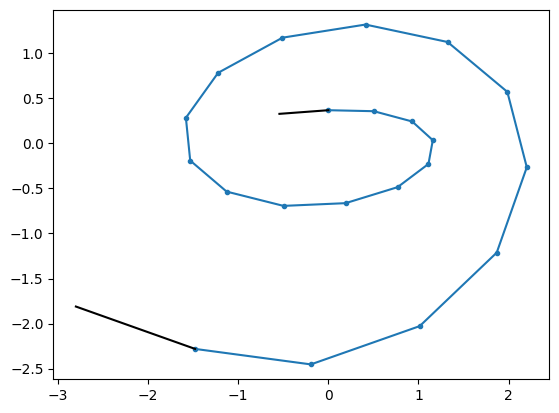

In [91]:
# solve for coefficients from second order Taylor series
# (assume uniform dt)
d0 = [-1.5, 2, -0.5] @ initial_p[:3]
d1 = [0.5, -2, 1.5] @ initial_p[-3:]

plt.figure()
plt.plot(initial_p[:,0], initial_p[:,1], '.-')
plt.plot(initial_p[0,0]-[0,d0[0]], initial_p[0,1]-[0,d0[1]], 'k-')
plt.plot(initial_p[-1,0]+[0,d1[0]], initial_p[-1,1]+[0,d1[1]], 'k-')
plt.axis("equal")
plt.show()

Interpolate spline (C2 cubic with end tangents)

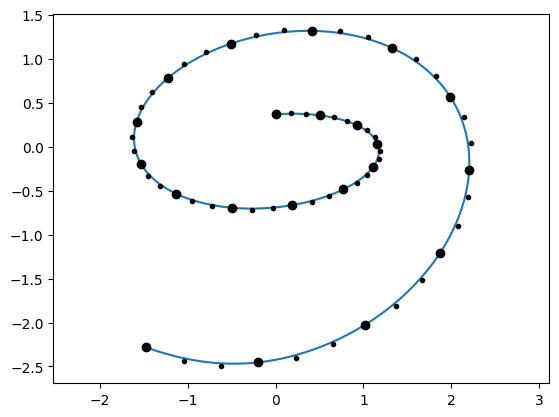

In [92]:
def compute_c1_c2(ps):
    n = len(ps)-1
    d0 = [-1.5, 2, -0.5] @ ps[:3]
    d1 = [0.5, -2, 1.5] @ ps[-3:]

    A = np.zeros((2*n, 2*n), dtype=np.double)
    b = np.zeros((2*n, 2), dtype=np.double)

    A[0,0] = 3.0
    b[0] = 3.0*ps[0] + d0
    for i in range(n-1):
        A[2*i+1, 2*i+1:2*i+3] = [1.0, 1.0]
        b[2*i+1] = 2.0*ps[i+1]
        A[2*i+2, 2*i:2*i+4] = [1.0, -2.0, 2.0, -1.0]
    A[2*n-1, 2*n-1] = 3.0
    b[2*n-1] = 3.0*ps[-1] - d1

    x = np.linalg.inv(A) @ b

    return x[2*np.arange(n)], x[2*np.arange(n)+1]


initial_c1, initial_c2 = compute_c1_c2(initial_p)

plt.figure()
for i in range(N):
    t = np.linspace(0, 1).reshape(-1, 1)
    p = (1-t)**3 * initial_p[i] + \
        3*t*(1-t)**2 * initial_c1[i] + \
        3*t**2*(1-t) * initial_c2[i] + \
        t**3 * initial_p[i+1]
    plt.plot(p[:,0], p[:,1], 'C0-')
plt.plot(initial_p[:,0], initial_p[:,1], 'ko')
plt.plot(x[:,0], x[:,1], 'k.')
plt.axis("equal")
plt.show()

Error metrics

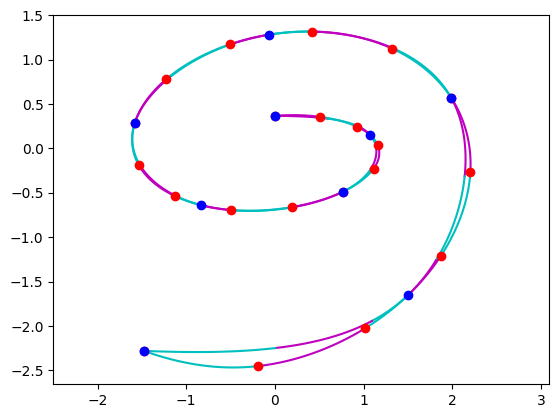

In [271]:
# https://cs.nyu.edu/~sw4429//files/paper/sa23-bezier.pdf


def unwrap_cubic_spline(cps, t0, t1):
    """Unwrap Bezier curve with control points c0,c1,c2,c3 between t0,t1 to
        polynomial spline with a0,a1,a2,a3 between 0,1"""
    coeffs = np.array([
        [1, 0, 0, 0],
        [-3, 3, 0, 0],
        [3, -6, 3, 0],
        [-1, 3, -3, 1]
    ]) @ cps
    dt = t1-t0
    return np.array([
        [1, t0, t0**2, t0**3],
        [0, dt, 2*t0*dt, 3*t0**2*dt],
        [0, 0, dt**2, 3*t0*dt**2],
        [0, 0, 0, dt**3]
    ]) @ coeffs


def get_loss(ts, ps, c1s, c2s, verbose=False):

    all_ss = []  # (s, is_initial, idx)
    for i, t in enumerate(initial_t):
        all_ss.append((t, True, i))
    for i, t in enumerate(ts):
        all_ss.append((t, False, i))
    all_ss.sort(key=lambda _: _[0])

    total_loss = 0.0
    sp0i, sp1i = 0, 0
    piece_i = 0
    for (s0, g0, i0), (s1, g1, i1) in zip(all_ss[:-1], all_ss[1:]):
        if g0:
            sp0i = i0
        else:
            sp1i = i0
        if not s0 < s1:
            continue
        piece_i += 1

        # first piece
        cps0 = (
            initial_p[sp0i], initial_c1[sp0i], initial_c2[sp0i],
            initial_p[sp0i+1]
        )
        t00, t01 = initial_t[sp0i], initial_t[sp0i+1]
        ts0 = ((s0-t00)/(t01-t00), (s1-t00)/(t01-t00))
        assert 0 <= ts0[0] < ts0[1] <= 1
        coeffs0 = unwrap_cubic_spline(cps0, *ts0)
        if verbose:
            t = np.linspace(0, 1).reshape(-1, 1)
            p = t**[0,1,2,3] @ coeffs0
            plt.plot(p[:,0], p[:,1], ['c-', 'm-'][piece_i%2])

        # second piece
        cps1 = (ps[sp1i], c1s[sp1i], c2s[sp1i], ps[sp1i+1])
        t10, t11 = ts[sp1i], ts[sp1i+1]
        ts1 = ((s0-t10)/(t11-t10), (s1-t10)/(t11-t10))
        assert 0 <= ts1[0] < ts1[1] <= 1
        coeffs1 = unwrap_cubic_spline(cps1, *ts1)
        if verbose:
            t = np.linspace(0, 1).reshape(-1, 1)
            p = t**[0,1,2,3] @ coeffs1
            plt.plot(p[:,0], p[:,1], ['c-', 'm-'][piece_i%2])

        # integral
        dc = coeffs1 - coeffs0
        dc_pows = np.einsum('ai,bi->ab', dc, dc) / np.array(
            [[1, 2, 3, 4],
             [2, 3, 4, 5],
             [3, 4, 5, 6],
             [4, 5, 6, 7]])
        loss = np.sum(dc_pows)

        # add loss
        dx0 = (ts0[1]-ts0[0])/N
        dx1 = (ts1[1]-ts1[0])/(len(ts)-1)
        if not (abs(dx1-dx0) < 1e-6):
            print(dx0, dx1)
            assert False
        weight = dx0/(t01-t00) + dx1/(t11-t10)
        total_loss += weight * loss
    
    return total_loss


n1 = 8
ts = np.linspace(0, 1, n1+1)
ps = fun(ts)
c1s, c2s = compute_c1_c2(ps)

plt.figure()
get_loss(ts, ps, c1s, c2s, True)
plt.plot(initial_p[:,0], initial_p[:,1], 'ro')
plt.plot(ps[:,0], ps[:,1], 'bo')
plt.axis("equal")
plt.show()

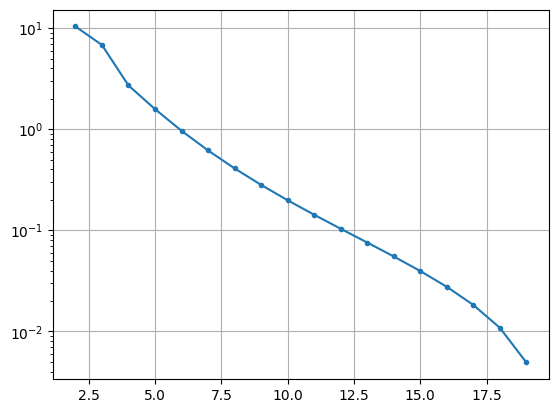

In [154]:
ns = range(2, N)
losses = []

for n1 in ns:
    ts = np.linspace(0, 1, n1+1)
    ps = fun(ts)
    c1s, c2s = compute_c1_c2(ps)
    loss = get_loss(ts, ps, c1s, c2s)
    losses.append(loss**0.5)

plt.figure()
plt.plot(ns, losses, '.-')
plt.yscale('log')
plt.grid()
plt.show()

Optimization

In [155]:
import torch

31 9.854861127678305e-05


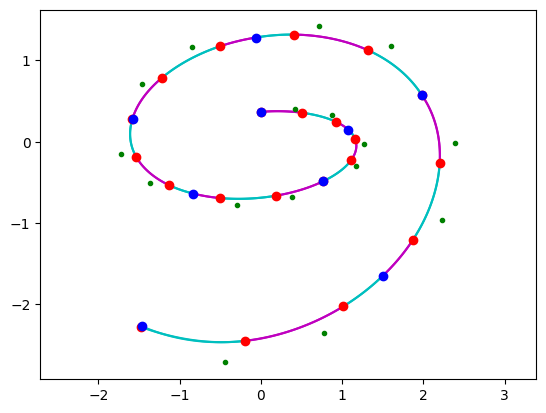

In [243]:
# https://cs.nyu.edu/~sw4429//files/paper/sa23-bezier.pdf


def unwrap_cubic_spline_torch(cps, t0, t1):
    """Unwrap Bezier curve with control points c0,c1,c2,c3 between t0,t1 to
        polynomial spline with a0,a1,a2,a3 between 0,1"""
    coeffs = torch.tensor([
        [1, 0, 0, 0],
        [-3, 3, 0, 0],
        [3, -6, 3, 0],
        [-1, 3, -3, 1]
    ]).float() @ cps
    dt = t1-t0
    return torch.tensor([
        [1, t0, t0**2, t0**3],
        [0, dt, 2*t0*dt, 3*t0**2*dt],
        [0, 0, dt**2, 3*t0*dt**2],
        [0, 0, 0, dt**3]
    ]).float() @ coeffs


def get_loss_torch(ts, ps, c1s, c2s):
    assert ts[0].item() == 0.0
    assert ts[-1].item() == 1.0

    initial_t_torch = torch.tensor(initial_t).float()

    all_ss = []  # (s, is_initial, idx)
    for i, t in enumerate(initial_t):
        all_ss.append((t, True, i))
    for i, t in enumerate(ts):
        all_ss.append((t, False, i))
    all_ss.sort(key=lambda _: _[0])

    total_loss = 0.0
    sp0i, sp1i = 0, 0
    for (s0, g0, i0), (s1, g1, i1) in zip(all_ss[:-1], all_ss[1:]):
        if g0:
            sp0i = i0
        else:
            sp1i = i0
        if not s0 < s1:
            continue

        # first piece
        cps0 = torch.tensor([
            initial_p[sp0i], initial_c1[sp0i], initial_c2[sp0i],
            initial_p[sp0i+1]
        ]).float()
        t00, t01 = initial_t_torch[sp0i], initial_t_torch[sp0i+1]
        ts0 = ((s0-t00)/(t01-t00), (s1-t00)/(t01-t00))
        coeffs0 = unwrap_cubic_spline_torch(cps0, *ts0)

        # second piece
        cps1 = torch.concatenate([
            ps[sp1i], c1s[sp1i], c2s[sp1i], ps[sp1i+1]
        ]).reshape((4, 2))
        t10, t11 = ts[sp1i], ts[sp1i+1]
        ts1 = ((s0-t10)/(t11-t10), (s1-t10)/(t11-t10))
        coeffs1 = unwrap_cubic_spline_torch(cps1, *ts1)

        # integral
        dc = coeffs1 - coeffs0
        dc_pows = torch.einsum('ai,bi->ab', dc, dc) / torch.tensor(
            [[1, 2, 3, 4],
             [2, 3, 4, 5],
             [3, 4, 5, 6],
             [4, 5, 6, 7]]).float()
        loss = torch.sum(dc_pows)

        # add loss
        dx0 = (ts0[1]-ts0[0])/N
        dx1 = (ts1[1]-ts1[0])/(len(ts)-1)
        weight = dx0/(t01-t00) + dx1/(t11-t10)
        total_loss += weight * loss
    
    return total_loss


def optimize_coeffs_torch(ts, ps, c1s, c2s):
    assert ts[0] == 0.0
    assert ts[-1] == 1.0

    ts = torch.nn.Parameter(torch.tensor(ts).contiguous().float())
    ps = torch.nn.Parameter(torch.tensor(ps).contiguous().float())
    c1s = torch.nn.Parameter(torch.tensor(c1s).contiguous().float())
    c2s = torch.nn.Parameter(torch.tensor(c2s).contiguous().float())

    optimizer = torch.optim.LBFGS([ps, c1s, c2s], max_iter=50)

    loss = 0.0
    nfev = 0
    def closure():
        nonlocal nfev, loss
        optimizer.zero_grad()
        loss = get_loss_torch(ts, ps, c1s, c2s)
        loss.backward()
        ts.grad[0] = 0.0
        ts.grad[-1] = 0.0
        # print(loss.item())
        nfev += 1
        return loss

    for epoch in range(1):
        optimizer.step(closure)

    return (nfev, loss.item()), (
        ts.detach().numpy(),
        ps.detach().numpy(),
        c1s.detach().numpy(),
        c2s.detach().numpy()
    )


n1 = 8
ts = np.linspace(0, 1, n1+1)
ps = fun(ts)
c1s, c2s = compute_c1_c2(ps)

(nfev, loss), (ts, ps, c1s, c2s) = optimize_coeffs_torch(ts, ps, c1s, c2s)
print(nfev, loss)

plt.figure()
get_loss(ts, ps, c1s, c2s, True)
plt.plot(initial_p[:,0], initial_p[:,1], 'ro')
plt.plot(ps[:,0], ps[:,1], 'bo')
plt.plot(c1s[:,0], c1s[:,1], 'g.')
plt.plot(c2s[:,0], c2s[:,1], 'g.')
plt.axis("equal")
plt.show()

22 107.62947085760757 0.7429438233375549
25 46.23827276909769 0.06774648278951645
30 7.321990818056995 0.0041799298487603664
30 2.498236739450082 0.0008895913488231599
31 0.9301076223010065 0.00027216749731451273
33 0.37992953635142795 0.00015216167957987636
31 0.16772577776116893 9.854861127678305e-05
30 0.07916752639056525 5.770335701527074e-05
26 0.03934294721681932 3.273776746937074e-05
25 0.02031447173070977 1.603738928679377e-05
26 0.010743308821999784 8.25430925033288e-06
21 0.005734522995581861 4.240724138071528e-06
21 0.0030394400920535935 2.219331236119615e-06
19 0.0015674243109213492 1.0499355767024099e-06
20 0.0007635021718154948 3.888178525812691e-07
19 0.00033435288937632383 1.707957864027776e-07
15 0.00011807490995765718 7.917238065147103e-08
12 2.43195318048815e-05 3.9413460939385914e-08


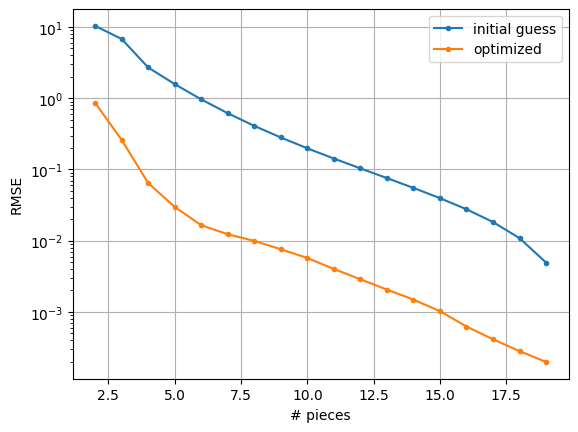

In [273]:
ns = range(2, N)
losses_0 = []
losses = []

for n1 in ns:
    ts = np.linspace(0, 1, n1+1)
    ps = fun(ts)
    c1s, c2s = compute_c1_c2(ps)
    loss0 = get_loss(ts, ps, c1s, c2s)
    (nfev, loss), (ts, ps, c1s, c2s) = optimize_coeffs_torch(ts, ps, c1s, c2s)
    print(nfev, loss0, loss)
    losses_0.append(loss0**0.5)
    losses.append(loss**0.5)

plt.figure()
plt.plot(ns, losses_0, '.-', label="initial guess")
plt.plot(ns, losses, '.-', label="optimized")
plt.yscale('log')
plt.grid()
plt.xlabel("# pieces")
plt.ylabel("RMSE")
plt.legend()
plt.show()

0.16772577166557312
0.06990154832601547
0.08811289817094803
0.1357363909482956
0.11129093170166016
0.07581833004951477
0.07386193424463272
0.0499349944293499
0.8530168533325195
9.758888244628906
85.59290313720703
14.106830596923828
86.81412506103516
21.627187728881836
23.961530685424805
2.6943612098693848
3.017707586288452
54.42588424682617
0.45720380544662476
0.24798041582107544
0.16838878393173218
0.09985275566577911
0.06173230707645416
0.050335340201854706
0.04116307571530342
0.022239813581109047
0.04504409059882164
0.006217195652425289
0.00419008219614625
0.0028582983650267124
0.002126686740666628
0.0018865385791286826
0.00166655657812953
0.0015030016656965017
0.0014195778639987111
0.0013889180263504386
0.0013805734924972057
0.001376038184389472
0.0013718216214329004
0.0013788804644718766
0.0014749335823580623
0.00142309395596385
0.001401267945766449
0.0013826002832502127
0.001380064175464213
0.00138292764313519
0.0014306785305961967
0.001612718217074871
0.002899404149502516
0.0066

AssertionError: 

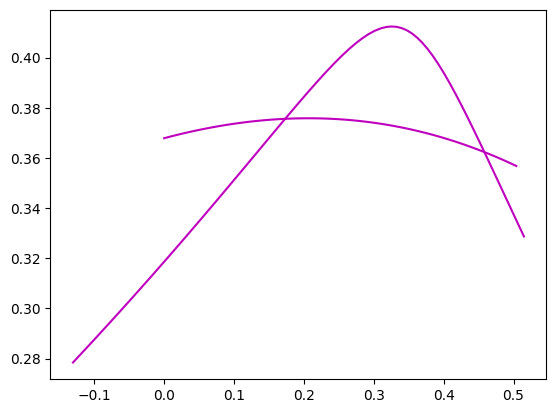

In [272]:
def optimize_coeffs_torch_with_ts(ts, ps, c1s, c2s):
    assert ts[0] == 0.0
    assert ts[-1] == 1.0

    softplus = torch.nn.Softplus()
    def map_ts(ts):
        # ts = torch.exp(ts)
        # ts = softplus(ts)
        ts = ts - torch.amin(ts) + 1.0
        ts = torch.cumsum(ts, 0)
        ts = torch.concatenate([torch.tensor([0.0]).float(), ts])
        return ts / ts[-1]
    
    def invmap_ts(ts):
        ts = torch.tensor(ts).float().contiguous()
        ts = ts[1:] - ts[:-1]
        # return torch.log(ts)
        # return torch.log(torch.exp(ts)-1)
        return ts

    ts_raw = torch.nn.Parameter(invmap_ts(ts))
    ps = torch.nn.Parameter(torch.tensor(ps).contiguous().float())
    c1s = torch.nn.Parameter(torch.tensor(c1s).contiguous().float())
    c2s = torch.nn.Parameter(torch.tensor(c2s).contiguous().float())

    optimizer = torch.optim.LBFGS([ts_raw, ps, c1s, c2s], max_iter=50)

    loss = 0.0
    nfev = 0
    def closure():
        nonlocal ts
        nonlocal nfev, loss
        optimizer.zero_grad()
        ts = map_ts(ts_raw)
        loss = get_loss_torch(ts, ps, c1s, c2s)
        loss.backward()
        print(loss.item())
        nfev += 1
        return loss

    for epoch in range(1):
        optimizer.step(closure)

    ts = map_ts(ts_raw)
    return (nfev, loss.item()), (
        ts.detach().numpy(),
        ps.detach().numpy(),
        c1s.detach().numpy(),
        c2s.detach().numpy()
    )


n1 = 8
ts = np.linspace(0, 1, n1+1)
ps = fun(ts)
c1s, c2s = compute_c1_c2(ps)

(nfev, loss), (ts, ps, c1s, c2s) = optimize_coeffs_torch_with_ts(ts, ps, c1s, c2s)
print(nfev, loss)

plt.figure()
get_loss(ts, ps, c1s, c2s, True)
plt.plot(initial_p[:,0], initial_p[:,1], 'ro')
plt.plot(ps[:,0], ps[:,1], 'bo')
plt.plot(c1s[:,0], c1s[:,1], 'g.')
plt.plot(c2s[:,0], c2s[:,1], 'g.')
plt.axis("equal")
plt.show()